In [1]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5, ), (0.5, ))
])
dataset = torchvision.datasets.MNIST('../data/mnist', train=True, transform=transform, download=False)

dataset[0][0].min(), dataset[0][0].max()

(tensor(0.), tensor(1.))

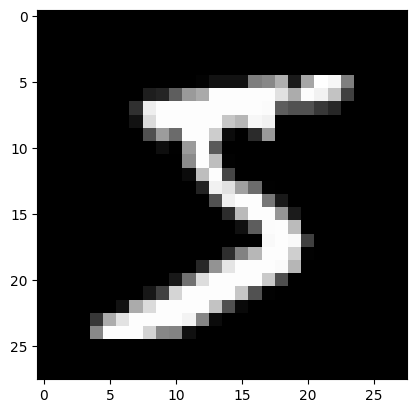

In [3]:
plt.imshow(dataset[0][0].permute(1, 2, 0), cmap='gray');

In [4]:
def show_images(images, nrow=8, title=None):
    plt.axis('off')
    plt.imshow(torchvision.utils.make_grid(images, nrow=nrow).permute(1, 2, 0))
    if title is not None:
        plt.title(title)
    plt.show()

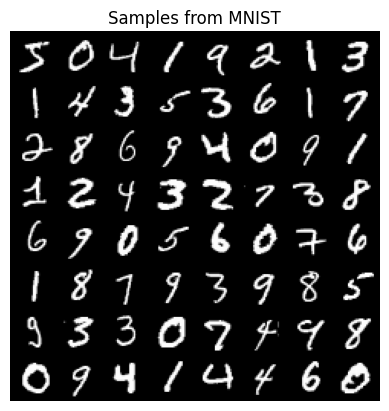

In [5]:
show_images(torch.stack([dataset[i][0] for i in range(64)]), title='Samples from MNIST');

In [6]:
class Encoder(nn.Module):
    def __init__(self, img_channels, hidden_dim, z_dim, num_classes, img_size=(28, 28)):
        super().__init__()

        self.z_dim = z_dim
        self.img_size = img_size

        self.class_embedding = nn.Embedding(num_classes, img_size[0]*img_size[1])
        
        self.net = nn.Sequential( # 28x28
            self.__basic_block(img_channels+1, hidden_dim, kernel_size=4, stride=2), # 13x13
            self.__basic_block(hidden_dim, hidden_dim*2, kernel_size=4, stride=2), # 5x5
            nn.Conv2d(hidden_dim*2, z_dim*2, kernel_size=4, stride=2), # 1x1
        )

    def __basic_block(self, in_channels, out_channels, kernel_size, stride):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(negative_slope=0.2)
        )

    def forward(self, x, labels):
        embd = self.class_embedding(labels).view(x.size(0), 1, *self.img_size)
        res = self.net(torch.cat((x, embd), dim=1)).reshape(x.shape[0], -1)

        return res[:, :self.z_dim], res[:, self.z_dim:].exp()

mu, sigma = Encoder(1, 20, 2, 10)(torch.randn(64, 1, 28, 28), torch.randint(0, 10, (64, )))
mu.shape, sigma.shape

(torch.Size([64, 2]), torch.Size([64, 2]))

In [7]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, img_channels, num_classes):
        super().__init__()

        self.class_embedding = nn.Embedding(num_classes, num_classes)

        self.net = nn.Sequential( # 1x1
            self.__basic_block(in_channels=z_dim+num_classes, out_channels=hidden_dim*4, kernel_size=3, stride=1), # 3x3
            self.__basic_block(in_channels=hidden_dim*4, out_channels=hidden_dim*2, kernel_size=4, stride=1), # 6x6
            self.__basic_block(in_channels=hidden_dim*2, out_channels=hidden_dim, kernel_size=3, stride=2), # 13x13
            nn.ConvTranspose2d(hidden_dim, img_channels, kernel_size=4, stride=2), # 28x28
            nn.Sigmoid(),
        )
    
    def __basic_block(self, in_channels, out_channels, kernel_size, stride):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    
    def forward(self, x, labels):
        embd = self.class_embedding(labels)
        return self.net(torch.cat((x, embd[:, :, None, None]), dim=1))
    
Decoder(2, 20, 1, 10)(torch.randn(64, 2, 1, 1), torch.randint(0, 10, (64, ))).shape

torch.Size([64, 1, 28, 28])

In [8]:
from torch.distributions.normal import Normal

class VariationAutoEncoder(nn.Module):
    def __init__(self, img_channels, hidden_dim, z_dim, num_classes=10):
        super().__init__()

        self.encoder = Encoder(img_channels, hidden_dim, z_dim, num_classes)
        self.decoder = Decoder(z_dim, hidden_dim, img_channels, num_classes)
    
    def forward(self, x, labels):
        mu, sigma = self.encoder(x, labels)
        dist = Normal(mu, sigma)
        z = dist.rsample()[:, :, None, None]
        decoded = self.decoder(z, labels)
        return dist, decoded

dist, decoded = VariationAutoEncoder(img_channels=1, hidden_dim=20, z_dim=2)(torch.randn(64, 1, 28, 28), torch.randint(0, 10, (64, )))
decoded.shape, dist.mean.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64, 2]))

In [9]:
from torch.distributions.kl import kl_divergence

reconstruction_loss = nn.BCELoss(reduction='sum')
kl_divergence_loss = lambda dist: kl_divergence(dist, Normal(torch.zeros_like(dist.mean), torch.ones_like(dist.stddev))).sum()

reconstruction_loss(torch.rand(64, 1, 28, 28), torch.rand(64, 1, 28, 28)), kl_divergence_loss(dist)


(tensor(50426.4414), tensor(34.3465, grad_fn=<SumBackward0>))

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [81]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

model = VariationAutoEncoder(img_channels=1, hidden_dim=20, z_dim=2).to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)

In [94]:
torch.norm(torch.tensor([[1, 1], [2, 2], [3, 3]], dtype=float), dim=1).sum()

tensor(8.4853, dtype=torch.float64)

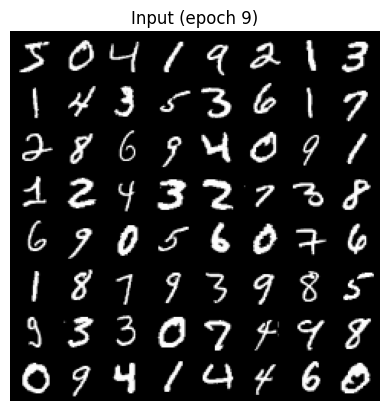

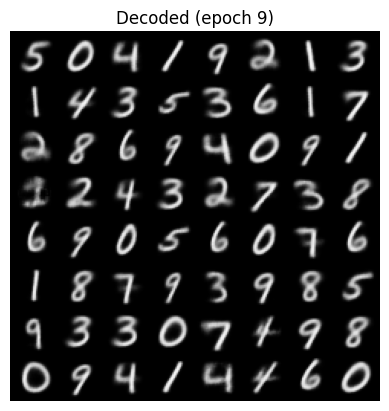

In [95]:
######## Testing my idea ########
for epoch in range(10):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        dist, decoded = model(images, labels)
        loss = reconstruction_loss(decoded, images)
        loss += torch.norm(dist.sample(), dim=1).sum()
        opt.zero_grad()
        loss.backward()
        opt.step()
    clear_output()
    show_images(torch.stack([dataset[i][0] for i in range(64)]), title=f'Input (epoch {epoch})');
    show_images(
        model(
            torch.stack([dataset[i][0] for i in range(64)]).to(device),
            torch.tensor([dataset[i][1] for i in range(64)]).to(device)
        )[1].cpu(),
        title=f'Decoded (epoch {epoch})'
    )


tensor(0.0757, device='cuda:0', grad_fn=<DivBackward0>)


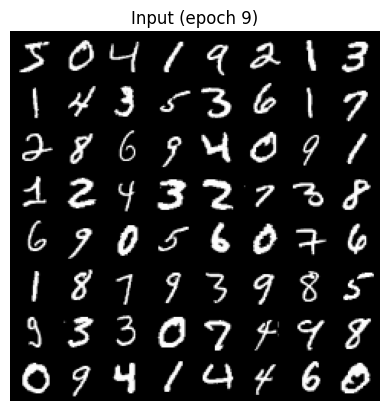

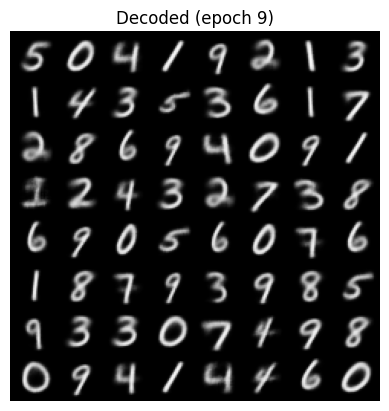

In [12]:
for epoch in range(10):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        dist, decoded = model(images, labels)
        loss = reconstruction_loss(decoded, images) + kl_divergence_loss(dist)
        opt.zero_grad()
        loss.backward()
        opt.step()
    clear_output()
    show_images(torch.stack([dataset[i][0] for i in range(64)]), title=f'Input (epoch {epoch})');
    show_images(
        model(
            torch.stack([dataset[i][0] for i in range(64)]).to(device),
            torch.tensor([dataset[i][1] for i in range(64)]).to(device)
        )[1].cpu(),
        title=f'Decoded (epoch {epoch})'
    )


In [96]:
model = model.cpu()

## Visualization

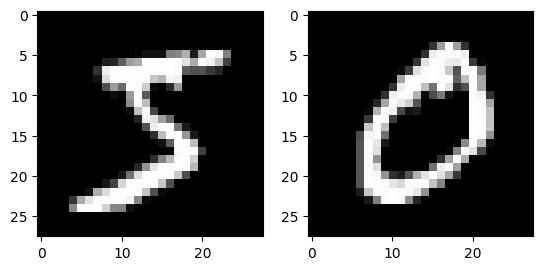

In [97]:
plt.subplot(1, 2, 1)
plt.imshow(dataset[0][0].permute(1, 2, 0), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(dataset[1][0].permute(1, 2, 0), cmap='gray');

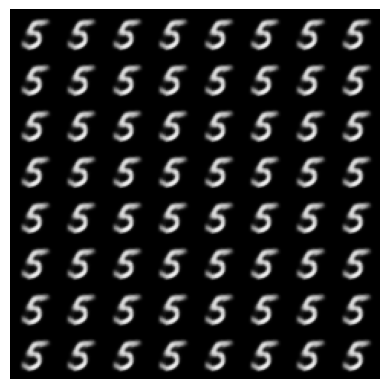

In [99]:
mu_1, sigma_1 = model.encoder(dataset[0][0].unsqueeze(0), torch.tensor(dataset[0][1]))
new_images = model.decoder(Normal(mu_1, sigma_1).sample_n(64).reshape(64, -1, 1, 1), torch.tensor(dataset[0][1]).repeat(64))
show_images(new_images);

In [100]:
# mu_2, sigma_2 = model.encoder(dataset[1][0].unsqueeze(0), torch.tensor(dataset[0][1]))
# t = torch.linspace(0, 1, 15)[:, None]
# interpolated_means = t@mu_2 + (1-t)@mu_1
# print(interpolated_means.shape)

# plt.figure(figsize=(15, 5))
# show_images(model.decoder(interpolated_means[:, :, None, None]), nrow=15);

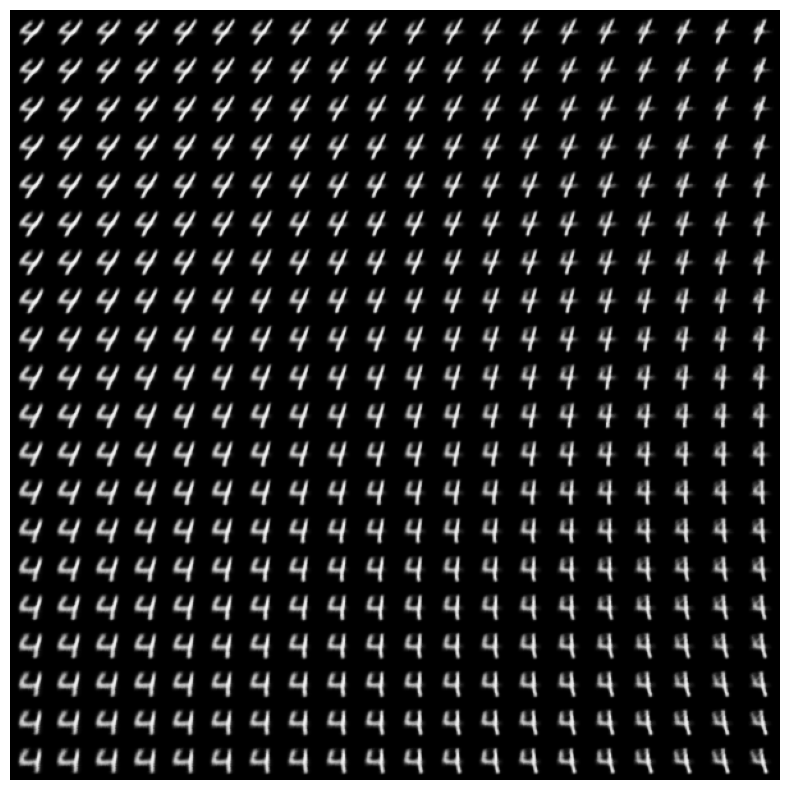

In [101]:
x_range = torch.linspace(-3, 3, 20)
y_range = torch.linspace(-3, 3, 20)
grid = torch.dstack(torch.meshgrid((x_range, y_range)))

plt.figure(figsize=(10, 10))
show_images(model.decoder(grid.reshape(-1, 2, 1, 1), torch.ones((400, ), dtype=torch.int)*4), nrow=20);

In [21]:
# images, labels = next(iter(torch.utils.data.DataLoader(dataset, batch_size=1024)))
# means = model.encoder(images)[0].detach()

# plt.figure(figsize=(8, 7))
# scatter = plt.scatter(means[:, 0], means[:, 1], c=labels, s=15)
# plt.legend(*scatter.legend_elements());

In [102]:
mean_images = []
std_images = []
encoded_labels = []
for images, labels in train_loader:
    m, s = model.encoder(images, labels)
    mean_images.append(m.detach())
    std_images.append(s.detach())
    encoded_labels.append(labels)
    
mean_images = torch.cat(mean_images, dim=0)
std_images = torch.cat(std_images, dim=0)
encoded_labels = torch.cat(encoded_labels)

mean_images.shape, std_images.shape, encoded_labels.shape

(torch.Size([60000, 2]), torch.Size([60000, 2]), torch.Size([60000]))

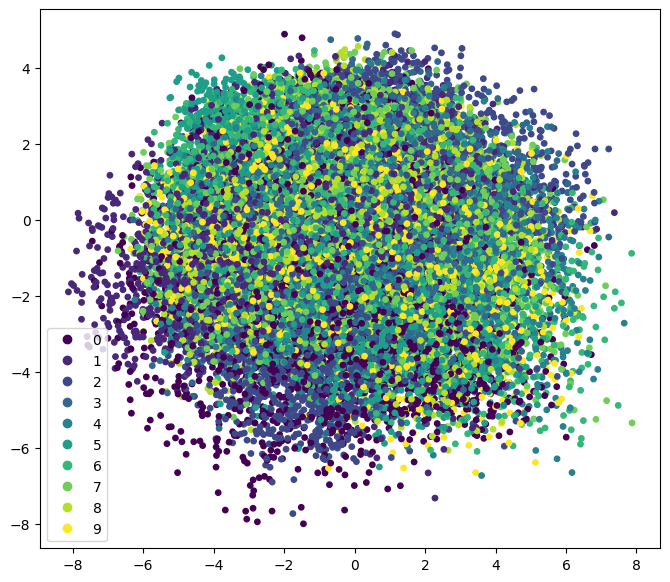

In [103]:
# images, labels = next(iter(torch.utils.data.DataLoader(dataset, batch_size=1024)))
# means = model.encoder(images)[0].detach()

plt.figure(figsize=(8, 7))
# scatter = plt.scatter(mean_images[:, 0], mean_images[:, 1], c=encoded_labels[:], s=15)
new = Normal(mean_images, std_images).sample()
scatter = plt.scatter(new[:, 0], new[:, 1], c=encoded_labels, s=15)
plt.legend(*scatter.legend_elements());

In [27]:
classes_mean, classes_std = torch.zeros((10, 2)), torch.zeros((10, 2))
for idx in range(10):
    classes_mean[idx] = torch.mean(mean_images[encoded_labels == idx], axis=0)
    classes_std[idx] = torch.mean(std_images[encoded_labels == idx], axis=0)
classes_mean, classes_std

(tensor([[-0.1108, -0.0983],
         [-0.0798, -0.0280],
         [ 0.0517, -0.0114],
         [-0.0281, -0.0829],
         [-0.0344, -0.1252],
         [-0.1784, -0.1144],
         [ 0.0862, -0.0128],
         [-0.0440, -0.1689],
         [-0.0094, -0.0954],
         [ 0.1005, -0.0671]]),
 tensor([[0.0945, 0.0845],
         [0.1394, 0.1031],
         [0.1116, 0.1221],
         [0.1386, 0.0996],
         [0.1107, 0.0779],
         [0.1503, 0.0901],
         [0.1227, 0.0698],
         [0.1264, 0.0802],
         [0.1438, 0.0888],
         [0.1363, 0.0743]]))

#### Same Style for constant Z (?)

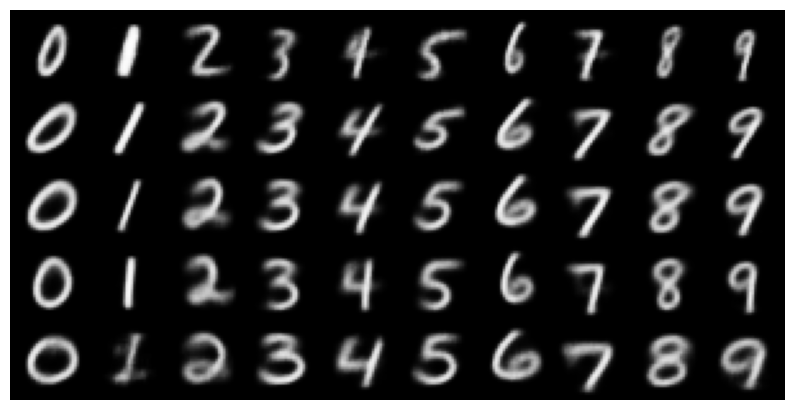

In [78]:
z = Normal(0, 1).sample((5, 1, 2)).repeat(1, 10, 1)
c = torch.arange(10).repeat(5, 1)

plt.figure(figsize=(10, 10))
show_images(model.decoder(z.reshape(-1, 2, 1, 1), c.flatten()), nrow=10);